In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import mplcursors 

In [2]:
runs = []  # List to store metadata and data
current_run = None
data_section = False

with open("b-bgo-20_lru_1.txt", "r") as file:
    for line in file:
        line = line.strip()

        if match := re.match(r"Motor-Position: (\d+)", line):
            if current_run:  # Store the previous run
                runs.append(current_run)
            current_run = {"Motor-Position": match.group(1), "Data": []}
            data_section = False
            
        elif match := re.match(r"Gate: (.+)", line):
            if current_run:  # Ensure current_run is initialized
                current_run["Gate"] = match.group(1)

        elif match := re.match(r"Pedestal: (.+)", line):
            if current_run:
                current_run["Pedestal"] = match.group(1)

        elif match := re.match(r"Run-Time: (.+)", line):
            if current_run:
                current_run["Run-Time"] = match.group(1)

        elif line == "Data:":  # Start data section
            data_section = True
            continue

        elif data_section and line:  # Collect numerical data
            #print(f"Processing line: {line}")  # Debugging
            try:
                numbers = list(map(int, line.split()))
                current_run["Data"].extend(numbers)
            except ValueError:
                print(f"⚠️ Skipping invalid line: {line}")  # Shows problem lines
            
    if current_run:  # Append last run data
        runs.append(current_run)

# ✅ Fixing print issue: Case-sensitive key lookup
for run in runs:
    # print(f"Motor Position {run['Motor-Position']} for Gate: {run.get('Gate', 'N/A')}"
    #       f"(Pedestal: {run.get('Pedestal', 'N/A')} for Run-time: {run.get('Run-Time', 'N/A')} s)")
    print(len(run['Data']))


⚠️ Skipping invalid line: >> 02/26/2025 14:32:13
⚠️ Skipping invalid line: Sample: BGO
⚠️ Skipping invalid line: Run-Type: 2
⚠️ Skipping invalid line: Source-Energy: 1.000000 (MeV)
⚠️ Skipping invalid line: Channel-PE: 1.000000
⚠️ Skipping invalid line: HV: 1689
⚠️ Skipping invalid line: >> 02/26/2025 14:35:38
⚠️ Skipping invalid line: Sample: BGO
⚠️ Skipping invalid line: Run-Type: 2
⚠️ Skipping invalid line: Source-Energy: 1.000000 (MeV)
⚠️ Skipping invalid line: Channel-PE: 1.000000
⚠️ Skipping invalid line: HV: 1689
⚠️ Skipping invalid line: >> 02/26/2025 14:42:45
⚠️ Skipping invalid line: Sample: BGO
⚠️ Skipping invalid line: Run-Type: 2
⚠️ Skipping invalid line: Source-Energy: 1.000000 (MeV)
⚠️ Skipping invalid line: Channel-PE: 1.000000
⚠️ Skipping invalid line: HV: 1689
⚠️ Skipping invalid line: >> 02/26/2025 14:46:35
⚠️ Skipping invalid line: Sample: BGO
⚠️ Skipping invalid line: Run-Type: 2
⚠️ Skipping invalid line: Source-Energy: 1.000000 (MeV)
⚠️ Skipping invalid line: Chan

In [3]:
int(run["Motor-Position"]) +1

126

17.63490314513
17.537873326532644
17.451846222786095
17.562390280500807
17.574798720496393
17.38553683174308
17.45135324722769


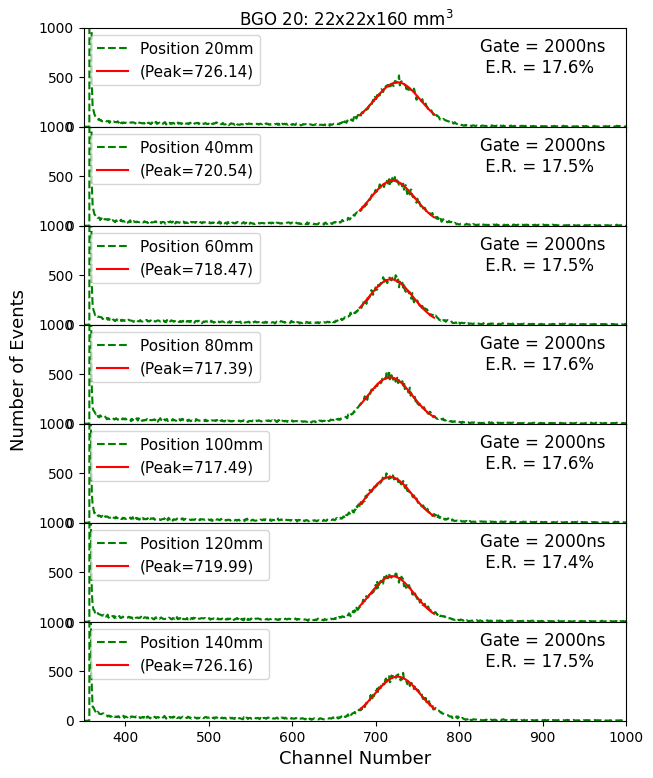

In [6]:

def gaussian(x, a, mu, sigma):
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma**2))


fig, axes = plt.subplots(len(runs), 1, figsize=(7,9), sharex=True, gridspec_kw={'hspace': 0})  # No space between subplots

for i, run in enumerate(runs):
    ax = axes[i]
    
    # Extract channels and light yield
    position = run["Motor-Position"]
    light_yield = run["Data"]
    channels = list(range(1, len(run["Data"]) + 1))
    # Plot data
    ax.plot(channels, light_yield, color= 'green', linestyle='--', label=f"Position {int(run['Motor-Position']) + 15}mm")
    ax.legend()
    
    # Fit Gaussian to a selected section (e.g., middle 20 points)
    fit_range = slice(680, 770)
    x_fit = np.array(channels[fit_range])
    y_fit = np.array(light_yield[fit_range])
    

    try:
        popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=[max(y_fit), np.mean(x_fit), np.std(x_fit)])
        fitted_y = gaussian(x_fit, *popt)
        fwhm = 2.355 * popt[2]  # FWHM for a Gaussian peak

        # Calculate energy resolution
        ER = (fwhm / (popt[1]-358)) * 100
        ax.text(0.73, 0.9, f'Gate = 2000ns \n E.R. = {ER:.1f}%', transform=ax.transAxes, fontsize=12, verticalalignment='top')
        ax.plot(x_fit, fitted_y, 'r', label=f"(Peak={popt[1]:.2f})")
        ax.set_ylim(0, 1000)
        ax.set_xlim(350, 1000)
        ax.legend(loc="upper left", fontsize = 11)
        
        print(f"{ER}")
    except RuntimeError:
        print(f"Gaussian fit failed for Run {run['Run ID']}")

    # Hide x-axis labels except for the last subplot
    if i < len(runs) - 1:
        ax.tick_params(labelbottom=False)

# Shared y-axis title
fig.supylabel("Number of Events", fontsize = 13)
#fig.supxlabel("Channel Number", fontsize = 13)
fig.suptitle("BGO 20: 22x22x160 mm$^3$", fontsize=12, y = 0.9 )
#plt.title('BGO 1: 22x22x160 mm$^3$')
plt.xlabel("Channel Number", fontsize = 13)
plt.show()


In [94]:
popt

array([435.68024988, 743.33275755,  28.58935858])